In [1]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

This model uses a neural network and GridSearchCV to predict share price impacts of Interest changes

# Read the CSV and Perform Basic Data Cleaning

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
df_stock1 = pd.read_csv("../../static/data/cba.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
5743,27/07/2022,96.510002,99.370003,96.459999,98.900002,98.900002,2221207,1.35,2.5,125.0
5744,28/07/2022,99.480003,100.199997,99.110001,99.889999,99.889999,3301364,1.35,2.5,125.0
5745,29/07/2022,100.300003,101.364998,100.099998,100.769997,100.769997,3122636,1.35,2.5,125.0
5746,1/08/2022,100.680000,101.080002,99.089996,101.080002,101.080002,2374671,1.35,2.5,125.0
5747,2/08/2022,100.989998,102.269997,100.430000,101.970001,101.970001,1905527,1.35,2.5,125.0


In [4]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

df_mongo = pd.DataFrame(list(db.cba.find()))

last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
# print(last_val)
print(last_date,last_close)
df_mongo.tail

12/08/2022 100.33999633789062


<bound method NDFrame.tail of                            _id        Date        Open        High  \
0     62ec7dd62a00b4164f22a9e0   3/01/2000   26.088652   26.088652   
1     62ec7dd62a00b4164f22a9e1   4/01/2000   26.058813   26.058813   
2     62ec7dd62a00b4164f22a9e2   5/01/2000   25.353634   25.392424   
3     62ec7dd62a00b4164f22a9e3   6/01/2000   25.362585   25.362585   
4     62ec7dd62a00b4164f22a9e4   7/01/2000   24.913021   25.113932   
...                        ...         ...         ...         ...   
5751  62f20f2001d5fbe0d6a6626c  08/08/2022  101.080002  102.889999   
5752  62f36ad1f103d381c683c43e  09/08/2022  102.190002  102.320000   
5753  62f6f76ea8ed5f12515de6b8  10/08/2022  101.279999  101.650002   
5754  62f6f76ea8ed5f12515de6b9  11/08/2022  101.400002  102.160004   
5755  62f6f76ea8ed5f12515de6ba  12/08/2022  100.150002  100.349998   

             Low       Close   Adj Close   Volume   RBA  FED    CPI  
0      26.088652   26.088652    7.993308        0  5.00  5.

# Use `RBA`,`FED` and `CPI` for the X values

In [5]:
X = df_mongo[["RBA","FED","CPI"]]
y = df_mongo["Close"].values.reshape(-1, 1)
print(X.shape, y.shape)

(5756, 3) (5756, 1)


In [6]:
X

,RBA,FED,CPI
0,5.00,5.5,69.7
1,5.00,5.5,69.7
2,5.00,5.5,69.7
3,5.00,5.5,69.7
4,5.00,5.5,69.7
...,...,...,...
5751,1.85,2.5,125.0
5752,1.85,2.5,125.0
5753,1.85,2.5,125.0
5754,1.85,2.5,125.0


# Create a Train Test Split

In [7]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train.info)

(4317, 3) (4317, 1)
(1439, 3) (1439, 1)
<bound method DataFrame.info of        RBA   FED    CPI
5018  1.00  2.25  115.4
2378  3.25  0.25   92.9
3223  3.50  0.25  101.8
5142  0.50  1.25  116.6
4432  1.50  1.00  110.7
...    ...   ...    ...
905   4.75  1.25   78.6
5192  0.25  1.25  114.4
3980  2.00  0.25  108.0
235   6.25  6.50   73.1
5157  0.25  1.25  114.4

[4317 rows x 3 columns]>


In [8]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fit the model

In [9]:
# Fit the model to the training data and calculate the scores for the training and testing data

### BEGIN SOLUTION
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.8794494059327315
Testing Score: 0.8719778692217841


In [10]:
# X_train = X_train.reshape((X_train.shape[0], 1))

In [11]:
#Linear Regression Residual showing difference actual vs predicted
# residual = pd.DataFrame([model.predict(X_train),y_train,(model.predict(X_train)-y_train)])
# residual.tail

Text(0.5, 1.0, 'Residual Plot')

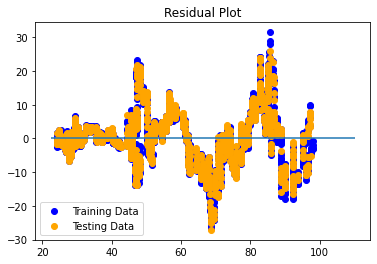

In [12]:
# Plot the Residuals for the Training and Testing data
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")

In [13]:
# Linear Regression: X_test predictions to variable
predictions = model.predict(X_test)

#### R2 Score is a very popular metric used for evaluating the performance of linear regression models. Where R2 Score is between 0 and 1, the closer to 1, the better the regression fit.
#### Use MSE or MAE when comparing two or more models, the lower the value of MSE or MAE, the better. MSE (Mean Square Error): Uses Euclidean distance to calculate the error. MSE gives the magnitude of the error only.

In [14]:
# Used X_test, y_test, and model.predict(X_test) to calculate MSE and R2

### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 62.878493146282295, R2: 0.8719778692217841


#### Lasso regression imposes a constraint on the model parameters that causes regression coefficients for some variables to shrink toward zero. It comes with a parameter, alpha , and the higher the alpha , the more feature coefficients are zero. When alpha is 0 , Lasso regression produces the same coefficients as a linear regression.

In [15]:
# LASSO model
# Note: Used an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train, y_train)

predictions = lasso.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = lasso.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 62.879955938044596, R2: 0.8719748909424246


In [16]:
# Ridge model
# Note: Used an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train, y_train)

predictions = ridge.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = ridge.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 62.878493835055544, R2: 0.8719778678194252


In [17]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train, y_train)

predictions = elasticnet.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = elasticnet.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 62.88087377715679, R2: 0.8719730221998232


# Hyperparameter Tuning

In [18]:
y_target = df_mongo["Close"]
y_target.shape

(5756,)

In [19]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_target, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4317, 3) (4317,)
(1439, 3) (1439,)


In [20]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(4317, 3) (4317,)
(1439, 3) (1439,)


#### GridSearchCV and RandomizedSearchCV are techniques to evaluate models for a given hyperparameter vector using cross-validation, hence the “CV” suffix of the class name.
#### We are executing many models together is to find which machine learning model works best for this particular dataset.

In [21]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [22]:
regressors = [
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

In [23]:
from time import time
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

RandomForestRegressor()
	Training time: 0.300s
	Prediction time: 0.022s
	Explained variance: 0.990870329708177
	Mean absolute error: 1.4540855620205326
	R2 score: 0.9908697064844292

DecisionTreeRegressor()
	Training time: 0.004s
	Prediction time: 0.002s
	Explained variance: 0.9908902961515935
	Mean absolute error: 1.452488257152728
	R2 score: 0.9908895459716693

KNeighborsRegressor()
	Training time: 0.004s
	Prediction time: 0.006s
	Explained variance: 0.9887963340365384
	Mean absolute error: 1.5825833581627458
	R2 score: 0.9887952275028388

GradientBoostingRegressor()
	Training time: 0.142s
	Prediction time: 0.005s
	Explained variance: 0.9868411304406408
	Mean absolute error: 1.8757041704875264
	R2 score: 0.9868382193932221

KNeighborsRegressor()
	Training time: 0.004s
	Prediction time: 0.006s
	Explained variance: 0.9887963340365384
	Mean absolute error: 1.5825833581627458
	R2 score: 0.9887952275028388

ExtraTreesRegressor()
	Training time: 0.212s
	Prediction time: 0.022s
	Explained v

#### By comparing these results, we can quickly see that RandomForestRegressor and DecisionTreeRegressor are the best models for our data
#### Machine learning models have parameters, which are the internal coefficients set by training or optimizing the model on a training dataset.
#### Parameters are different from hyperparameters. Parameters are learned automatically; hyperparameters are set manually to help guide the learning process.

In [24]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [25]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [27]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [28]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 1.4545 degrees.
Accuracy = 97.42%.
Model Performance
Average Error: 1.4524 degrees.
Accuracy = 97.43%.
Improvement of 0.01%.


In [29]:
# Hyperparameter tuning has not improved accuracy significantly

In [30]:
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train, y_train)
y_test_pred = model_rfr.predict(X_test)
y_test_pred

array([91.88753603, 27.68860854, 47.34768867, ..., 37.88792928,
       29.84842867, 46.8413253 ])

In [31]:
#RandomForestRegressor Residual showing difference actual vs predicted
residual_dtr = pd.DataFrame([model_rfr.predict(X_train),y_train,(model_rfr.predict(X_train)-y_train)])
residual_dtr.tail

<bound method NDFrame.tail of         0          1          2          3          4          5     \
0  79.119118  35.614538  54.928986  68.253632  83.135251  79.455934   
1  81.690002  36.621586  55.240704  63.110001  81.000000  76.070000   
2  -2.570884  -1.007048  -0.311718   5.143631   2.135251   3.385934   

        6          7          8          9     ...       4307       4308  \
0  29.848429  29.872068  54.928986  28.516967  ...  75.465430  27.568513   
1  31.315332  29.788605  55.011944  29.002863  ...  77.800003  27.869005   
2  -1.466903   0.083463  -0.082958  -0.485896  ...  -2.334573  -0.300492   

        4309       4310       4311       4312       4313       4314  \
0  79.969204  51.344113  50.331111  26.541174  63.190719  80.257658   
1  79.040001  52.873531  50.178135  30.355534  58.990002  81.677467   
2   0.929203  -1.529418   0.152976  -3.814360   4.200717  -1.419809   

        4315       4316  
0  29.848429  63.190719  
1  30.972193  61.240002  
2  -1.123764   1.

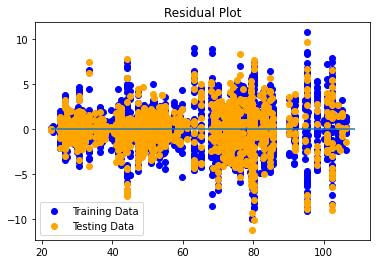

In [32]:
# Make predictions using fitted model
predictions1 = model_rfr.predict(X_test)

# Plotted the difference between the model predicted values and actual y values, versus the model predicted values
plt.scatter(model_rfr.predict(X_train), y_train - model_rfr.predict(X_train), c="blue", label="Training Data")
plt.scatter(model_rfr.predict(X_test), y_test - model_rfr.predict(X_test), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

# Save the Model

In [33]:
import pickle
filename = '../../static/cba_model_rfr.sav'
pickle.dump(model, open(filename, 'wb'))
model_in_rfr = pickle.load(open(filename, 'rb'))

In [34]:
# from joblib import dump,load
# model_in_rfr = load('cba_model_rfr.sav')

In [35]:
rba = float(0.85)
fed = float(1.75)
cpi = float(125.00)
input =40
rfr=[]

def randomforest(rba,fed,cpi):
    for i in range(0,input):
      rfr.append([rba,fed,cpi])
      np.round_(rfr,2,out = None) 
      df = pd.DataFrame(rfr, columns = ['RBA','FED',"CPI"])
      df.round(2)
      pred_rf=model_in_rfr.predict(df)
      df['Prediction'] = pred_rf
      df['Prediction'] = df['Prediction'].astype(float).round(2)
      rba+=0.01
      fed+=0.01
      cpi+=0.01
      print(df)
    my_rforest = df.to_dict(orient='records')
    for dict_value in my_rforest:
      for k, v in dict_value.items():
        dict_value[k] = round(v, 2)
    return my_rforest
# print(my_rforest)
my_rf = randomforest(rba,fed,cpi)
print(my_rf)


    RBA   FED    CPI  Prediction
0  0.85  1.75  125.0       97.27
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00       97.27
1  0.86  1.76  125.01       97.29
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00       97.27
1  0.86  1.76  125.01       97.29
2  0.87  1.77  125.02       97.31
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00       97.27
1  0.86  1.76  125.01       97.29
2  0.87  1.77  125.02       97.31
3  0.88  1.78  125.03       97.33
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00       97.27
1  0.86  1.76  125.01       97.29
2  0.87  1.77  125.02       97.31
3  0.88  1.78  125.03       97.33
4  0.89  1.79  125.04       97.34
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00       97.27
1  0.86  1.76  125.01       97.29
2  0.87  1.77  125.02       97.31
3  0.88  1.78  125.03       97.33
4  0.89  1.79  125.04       97.34
5  0.90  1.80  125.05       97.36
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00       97.27
1  0.86  1.76  1

In [36]:
rba = float(0.85)
fed = float(1.75)
cpi = float(125.00)
def rforest(rba,fed,cpi):
    dtr =[[rba,fed,cpi]]
    df = pd.DataFrame (dtr, columns = ['RBA','FED',"CPI"])
    pred_dtr=model_in_rfr.predict(df)
    df['Prediction'] = pred_dtr
    print(df)
    df_dict = df.to_dict(orient='records')
    return pred_dtr
Pred_rf = rforest(rba,fed,cpi)
print(Pred_rf)

    RBA   FED    CPI  Prediction
0  0.85  1.75  125.0   97.266409
[97.26640872]


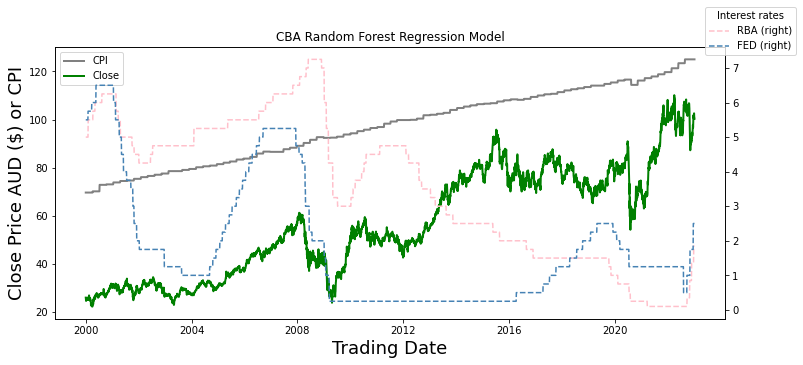

In [37]:
x = np.arange(2000,2024,4)
ax = df_mongo.plot(y=["CPI","Close"], figsize=(12, 5),color=['grey','green'],linewidth=2)
df_mongo.plot(y=["RBA","FED"],secondary_y=True, ax=ax,color=['pink','steelblue'],linestyle='dashed')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=-4, title="Interest rates")
ax.legend(loc='upper left')
ax.set_xticks([0,1000,2000,3000,4000,5000])
ax.set_xticklabels(x, rotation=0)
ax.set_title('CBA Random Forest Regression Model')
ax.set_xlabel('Trading Date', fontsize=18)
ax.set_ylabel('Close Price AUD ($) or CPI', fontsize=18)
plt.savefig('../../static/data/images/cba_tree.png')

#Save predicted error to MongoDB

In [38]:
# Module used to connect Python with MongoDb
import pymongo

In [39]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# Define the 'sharesDB' database in Mongo
db = client.sharesDB.companys

name = 'CBA'

In [40]:
# query the companys collection
companys = db.find({'model': 'RFR','name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f22c944569e8a2848fddd5'), 'model': 'RFR', 'name': 'CBA', 'date': '09/08/2022', 'predicted': 97, 'actual': 101, 'difference': -3.9884, 'accuracy': 97.45}


In [41]:
#save last price actual to variable
actual_price = df_mongo.iloc[-1,5]
actual_date = df_mongo.iloc[-1,1] 
actual_price = int(actual_price)
base_accuracy=round(base_accuracy,2)
print(base_accuracy,actual_price,actual_date)

97.42 100 12/08/2022


In [42]:
# Set keys and values of company

predicted = int(Pred_rf)
difference = Pred_rf-actual_price
difference=difference[0]
print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference},accuracy {base_accuracy}')

date 12/08/2022,predicted 97,actual 100, difference -2.7335912755453506,accuracy 97.42


In [43]:
# Delete a document from a collection
db.delete_one(
    {'model': 'RFR','name': name}
)


In [44]:
# Insert a document into the 'companys' collection
db.insert_one(
    {
      'model': 'RFR',
      'name': name,
      'date': actual_date,
      'predicted': predicted,
      'actual': actual_price,
      'difference': round(difference,4),
      'accuracy': round(base_accuracy,2)        
    }
)

# query the classroom collection
companys = db.find({
      'model': 'RFR',
      'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f869a32d48e159f9650d6b'), 'model': 'RFR', 'name': 'CBA', 'date': '12/08/2022', 'predicted': 97, 'actual': 100, 'difference': -2.7336, 'accuracy': 97.42}
